In [1]:
import numpy as np
import seaborn as sns
import scipy.optimize as op
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Parameters

In [2]:
#Parameters
min_error = 10000;
Ntrails =500;
Nsamps = 100; #number of smaples across period of the grating (even number)
Ncoefs = 5; #number of Fourier coefficients
Nspots = 5; #number of spots for analysis in Fourier plane (odd number)
Q_levels = 8; #Number of quantization levels (power of 2)

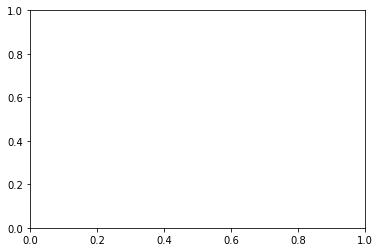

In [3]:
fig, ax = plt.subplots()

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata,ydata)
    return ln,

In [5]:
def imageerror_Binary(cm_in, inparms):
    #function imageerror_Binary
    #uses Fourier coefficiencts to calculate profile

    #parameters
    Nsamps = inparms[0];
    Nspots = inparms[1];
    Ncoefs= inparms[2];
    Q_levels= inparms[3];

    #xvector
    xvec        = np.linspace(-0.5,0.5,Nsamps)

    #make transmission phase 
    xprofile    = np.zeros(Nsamps)
    for ii in range(Ncoefs):
        xprofile    = xprofile + cm_in[ii]*np.cos(2*np.pi*xvec*(ii-1))

    maxprofile  = max(xprofile)
    minprofile  = min(xprofile)
    xprofilenorm    = (xprofile-minprofile)/(maxprofile-minprofile)
    Q_profile   = np.floor(xprofilenorm*Q_levels)/Q_levels
    indx        = np.where(Q_profile == 1)
    if Q_levels == 2:
        Q_profile[indx]   = 1/Q_levels
    else:
        Q_profile[indx]   = (Q_levels-1)/Q_levels

    Q_profile   = (Q_profile+minprofile)*(maxprofile-minprofile)
#     plt.figure(10)
#     plt.plot(Q_profile)
#     plt.show()

    tvec        =  np.exp(1j*2*np.pi*Q_profile)

    #take fft mag sq and normalize
    fullfield   = np.fft.fftshift(abs(np.fft.fft(tvec))**2)/Nsamps/Nsamps*Nspots

    #define mask
    indxstart = np.ceil(Nsamps/2-Nspots/2)
    indxstop  = np.floor(Nsamps/2 + Nspots/2)
    indx        = np.arange(indxstart,indxstop)
    mask        = np.zeros(Nsamps)
    for i in indx:
        mask[int(i)]  = 1

    #error calculation
    errorvalA   = sum(((fullfield/max(fullfield) - mask)*mask)**2)
    powinmask   = sum(fullfield*mask)/Nspots
    errorvalB    = 1/powinmask**2
    errorval    = errorvalA # + errorvalB

    return errorval

## Optimization Routine

In [6]:
for jj in range(Ntrails):
    
    cm0     = 0.2*(0.5 - np.random.rand(Ncoefs))   #initial Fourier coefficient vector

    #form initial guess for transition points
    #assume symmetric distribution of transitionssd
    xvec        = np.linspace(-0.5,0.5,Nsamps)

    inparms = [Nsamps,Nspots,Ncoefs,Q_levels]

    #find minimum error
    cm_in       = lambda cm_in: imageerror_Binary(cm_in, inparms)
    cmout       = op.fmin(cm_in, cm0, maxiter= 50000, maxfun= 50000, disp=False)

    #calculate profile
    xprofile    = np.zeros(Nsamps)
    for ii in range(Ncoefs):
        xprofile    = xprofile + cmout[ii]*np.cos(2*np.pi*xvec*(ii-1))

    maxprofile  = max(xprofile)
    minprofile  = min(xprofile)
    xprofilenorm    = (xprofile-minprofile)/(maxprofile-minprofile)
    Q_profile   = np.floor(xprofilenorm*Q_levels)/Q_levels
    indx        = np.where(Q_profile == 1)
    if Q_levels == 2:
        Q_profile[indx]   = 1/Q_levels
    else:
        Q_profile[indx]= (Q_levels-1)/Q_levels

    Q_profile   = (Q_profile+minprofile)*(maxprofile-minprofile)

#     plt.figure(10)
#     plt.plot(Q_profile)
#     plt.show()
    tvec        =  np.exp(1j*2*np.pi*Q_profile)

    #error calculation
    #take fft, shift and normalize
    fullfield   = np.fft.fftshift(abs(np.fft.fft(tvec))**2)/Nsamps/Nsamps*Nspots

    #make mask
    indx        = np.arange(np.ceil(Nsamps/2 - Nspots/2), np.floor(Nsamps/2 + Nspots/2))
    mask        = np.zeros(Nsamps)
    for i in indx:
        mask[int(i)]  = 1

    #calculate values
    fullfieldnorm       = fullfield/max(fullfield)
    fullfieldavgmask    = sum(fullfieldnorm*mask)/Nspots
    uniformity  = sum(((fullfieldnorm - fullfieldavgmask)*mask)**2)
    powinmask   = sum(fullfield*mask)/Nspots

    #calculate error
    errorval    = sum(((fullfieldnorm - mask)*mask)**2)
    
    if errorval < min_error:
        min_error=errorval
        cmout_save = cmout
        print([' Trial ' + str(jj) + ' errorval = ' + str(errorval)])
        

[' Trial 0 errorval = 0.6468062277401428']
[' Trial 1 errorval = 0.23328248368597415']
[' Trial 2 errorval = 0.011929752071116174']
[' Trial 5 errorval = 0.002427683725561758']
[' Trial 10 errorval = 0.00011399488601747417']
[' Trial 28 errorval = 5.292742454177582e-06']
[' Trial 272 errorval = 2.5047807958400433e-06']
[' Trial 324 errorval = 1.0534607703114765e-07']


Note: As Nspots increases, you will probably need to increase Nsamps in
order to get good uniformity.  However, this increases the accuracy
required for fabrication and the tolerance sensitivity to the transition
positions.

## Analysis

In [7]:
print("optimum Fourier coefficients: ")
print(str(cmout_save))

optimum Fourier coefficients: 
[0.07435145 0.26919297 0.14664532 0.29687949 0.02809662]


In [8]:
#calculate profile
xvec        = np.linspace(-0.5,0.5,Nsamps);
xprofile    = np.zeros(Nsamps);
for ii in range(Ncoefs):
    xprofile    = xprofile + cmout_save[ii]*np.cos(2*np.pi*xvec*(ii-1))

maxprofile  = max(xprofile);
minprofile  = min(xprofile);
xprofilenorm    = (xprofile-minprofile)/(maxprofile-minprofile)
Q_profile   = np.floor(xprofilenorm*Q_levels)/Q_levels;
indx        = np.where(Q_profile == 1);
if Q_levels == 2:
    Q_profile[indx]   = 1/Q_levels;
else:
    Q_profile[indx]   = (Q_levels-1)/Q_levels;

Q_profile   = (Q_profile+minprofile)*(maxprofile-minprofile)
#plt.figure(10)
#plt.plot(Q_profile)

tvec        =  np.exp(1j*2*np.pi*Q_profile);

#take fft, shift and normalize
fullfield   = np.fft.fftshift(abs(np.fft.fft(tvec))**2)/Nsamps/Nsamps*Nspots;

#make mask
indx        = (np.ceil(Nsamps/2 - Nspots/2),np.floor(Nsamps/2 + Nspots/2))
mask        = np.zeros(Nsamps)
for i in indx:
    mask[int(i)]  = 1

#calculate values
fullfieldnorm       = fullfield/max(fullfield)
fullfieldavgmask    = sum(fullfieldnorm*mask)/Nspots
uniformity  = sum(((fullfieldnorm - fullfieldavgmask)*mask)**2)
powinmask   = sum(fullfield*mask)/Nspots
ordervec    = np.arange(-Nsamps/2,(Nsamps/2))

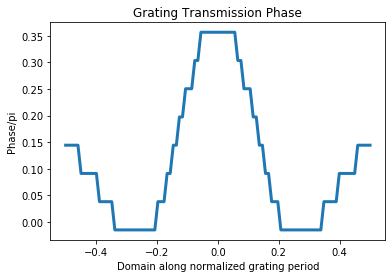

Text(1, 0.75, "['power in mask = 0.2477 ']")

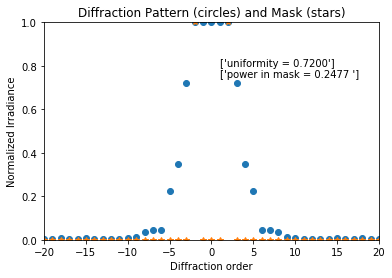

In [9]:
plt.figure(31)
plt.plot(xvec,Q_profile/2,linewidth=3)
plt.title('Grating Transmission Phase')
plt.xlabel('Domain along normalized grating period')
plt.ylabel('Phase/pi')
plt.show()
plt.figure(30)
plt.plot(ordervec,fullfield/max(fullfield),'o',ordervec,mask,'*')
plt.axis([-20, 20, 0, 1])
plt.title('Diffraction Pattern (circles) and Mask (stars)')
plt.xlabel('Diffraction order')
plt.ylabel('Normalized Irradiance')
plt.text(1,0.8,['uniformity = %0.4f' % uniformity ])
plt.text(1,0.75,['power in mask = %0.4f ' % powinmask ])